In [1]:
import torch.utils.data as data
from PIL import Image
import os
import os.path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as nninit
import torchvision
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm
import time
import numpy as np
import random
import torch.optim as optim

In [9]:
def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension.
    Args:
        filename (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in extensions)

def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

def make_dataset(dir, class_to_idx, extensions):
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if has_file_allowed_extension(fname, extensions):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    images.append(item)

    return images

class DatasetFolder(data.Dataset):
    """A generic data loader where the samples are arranged in this way: ::
        root/class_x/xxx.ext
        root/class_x/xxy.ext
        root/class_x/xxz.ext
        root/class_y/123.ext
        root/class_y/nsdf3.ext
        root/class_y/asd932_.ext
    Args:
        root (string): Root directory path.
        loader (callable): A function to load a sample given its path.
        extensions (list[string]): A list of allowed extensions.
        transform (callable, optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.RandomCrop`` for images.
        target_transform (callable, optional): A function/transform that takes
            in the target and transforms it.
     Attributes:
        classes (list): List of the class names.
        class_to_idx (dict): Dict with items (class_name, class_index).
        samples (list): List of (sample path, class_index) tuples
    """

    def __init__(self, root, loader, extensions, transform=None, target_transform=None):
        classes, class_to_idx = find_classes(root)
        samples = make_dataset(root, class_to_idx, extensions)
        if len(samples) == 0:
            raise(RuntimeError("Found 0 files in subfolders of: " + root + "\n"
                               "Supported extensions are: " + ",".join(extensions)))

        self.root = root
        self.loader = loader
        self.extensions = extensions

        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        
        #target = torch.zeros((len(self.classes)))        
        #target[target0] = 1
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self):
        return len(self.samples)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str
    
    def shuffle_set(self):
        random.shuffle(self.samples)
        


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)
    


In [10]:
IMG_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm']
root = 'train_done_set'
done_train_set = DatasetFolder(root, pil_loader, IMG_EXTENSIONS)

In [38]:
class Done_classify(nn.Module):
    def __init__(self):
        super(Done_classify, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size = 5, stride = 2 ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size = 5, stride = 2 ),
            nn.BatchNorm2d(32),
            nn.ReLU())
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size = 3, stride = 2 ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.linear1 = nn.Sequential(
        nn.Linear(32*5*6,300),
        nn.ReLU(),
        nn.Linear(300,2))
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.linear1(out.view(-1,32*5*6))
        return out
        

In [39]:

done_mod = Done_classify()
done_mod = done_mod.cuda(0)
trans = torchvision.transforms.ToTensor()
epoch_num = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(done_mod.parameters(), lr=0.01)
    

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

1
1
1
1
1
0
1
1
1
1
0
1
0
1
0
1
1
1
0
1
1
1
0
1
1
1
1
1
1
0
1
1
0
1
0
0
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
1
1
0
1
0
1
1
1
1
1
1
0
1
1
1
1
0
1
1
0
1
0
1
1
1
1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
0
0
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
0
0
1
1
0
0
1
0
0
1
1
1
1
1
1
0
0
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
0
0
1
1
1
1
0
1
1
0
0
1
1
1
1
1
1
0
0
1
1
1
1
0
1
1
1
1
1
1
1
0
1
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
0
1
1
1
0
1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
0
0
1
1
0
0
0
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
0
1
1
1
0
1
1
1
1
1
0
1
1
0
1
0
1
1
1
1
1
1
0
1
0
0
1
0
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
0
0
0
1
0
1
1
1
0
1
1
0
0
1
1
1
1
1
0
0
1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
0
0
1
1
0
1
1
1
1
1
1
0
1
0
0
0
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
0
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
0
1
1
0
1
1
1
1
1
1
1
0
1


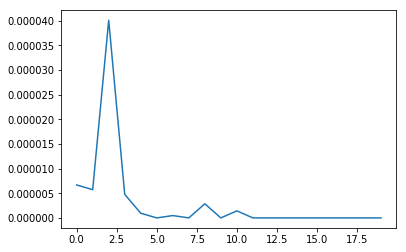

In [41]:
loss_plot = []
for epoch in tqdm(range(epoch_num)):
    done_train_set.shuffle_set()
    
    for img,label in done_train_set:
        print(label)
        done_mod.zero_grad()
        img = Variable(trans(img))
        img = img.cuda(0)

        label = torch.LongTensor([label]).cuda(0)

        label = Variable(label)
        img.unsqueeze_(0)
        output_net = done_mod(img)
        loss = criterion(output_net, label)
        loss.backward()
        optimizer.step()
        
    loss_plot.append(loss.data[0])
plt.plot(loss_plot)

In [43]:
torch.save(done_mod.state_dict(), 'done_mod.pt')

In [ ]:
done_mod = Done_classify()
done_mod.load_state_dict(torch.load('done_mod.pt'))
done_mod = done_mod.cuda(0)

In [44]:
IMG_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm']
root = 'train_done_set'

done_train_set = DatasetFolder(root, pil_loader, IMG_EXTENSIONS)
done_train_set.shuffle_set()
for img,label in done_train_set:
    print(img.size)
    print(type(img))
    img = Variable(trans(img))
    
    print(type(img))
    img = img.cuda(0)
    print(label)
    label = torch.LongTensor([label]).cuda(0)
    
    label = Variable(label)
    img.unsqueeze_(0)
    output_net = done_mod(img)
    values, indices = torch.max(output_net,1)
    
    print(indices)

(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
1
Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]

(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
1
Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]

(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
1
Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]

(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
1
Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]

(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
1
Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]

(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
0
Variable containing:
 0
[torch.cuda.LongTensor of size 1 (GPU 0)]

(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
1
Variable containing:
 1



(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
1
Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]

(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
0
Variable containing:
 0
[torch.cuda.LongTensor of size 1 (GPU 0)]

(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
1
Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]

(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
1
Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]

(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
1
Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]

(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
1
Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]

(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
1
Variable containing:
 1


(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
1
Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]

(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
1
Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]

(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
1
Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]

(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
1
Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]

(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
1
Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]

(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
1
Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]

(216, 192)
<class 'PIL.Image.Image'>
<class 'torch.autograd.variable.Variable'>
0
Variable containing:
 0